# Notebook activity A2.9 Applying the First Differences (FD) and the Anderson-Hsiao (AH) estimators using R 

In this notebook activity, we will be return to the modelling of panel data series, now also taking into account their time properties. We will be using the PSID dataset that was introduced in Unit A1, Section 3.2.3, to estimate the Mincerian equation, 

$ \log(\texttt{wage})_{it} = \alpha_0 + \alpha_1\ \texttt{educ}_{i} + \alpha_2\ \texttt{exper}_{it} + \alpha_3\ \texttt{exper}^2_{it} + \alpha_4\ \texttt{occupation}_{it} + \alpha_5\ \texttt{gender}_{i} + \alpha_6\ \texttt{ethnicity}_{i} + u_{it}$

As a reminder, the variables in this dataset are

* `exper`: the number of years of full-time experience
* `occupation`: taking values 1 (blue-collar occupation) and 0 (other occupations)
* `gender`: taking values 0 (male) and 1 (female)
* `educ`: the number of years of education
* `ethnicity`: taking values 1 (black) and 0 (otherwise)
* `wageLog`: natural logarithm of hourly wages (in cents of a dollar)
* `period`: year of the study that the observation relates to
* `id`: individual.

The data for the PSID dataset is stored in the `psid` data frame.

## (a) Getting started

### (i) 

Start by running the following code.

In [ ]:
# Load the M348 package
library(M348)
# Load the psid data frame
data(psid)
# Check the data frame has loaded OK
head(psid,14)
tail(psid, 14)

### (ii)

Calculate a new variable `experSq` that contains the square of experience and add it to `psid`.

#### Solution <a class="tocSkip">

The required code is as follows. Note that this will not produce any output.

In [2]:
psid$experSq <- psid$exper^2

### (iii)

Load the `plm` package and create a panel data frame called `psidPanel` from `psid`. (Look back at Notebook activity A1.5 if you need a reminder of how to do this.)

#### Solution <a class="tocSkip">

The required is given below. Note that running this will not produce any output.

In [3]:
library(plm)
psidPanel <- pdata.frame(psid, index = c("id", "period"))

## (b) Refamiliarising ourselves with the data

In Notebook activity A1.5 you explored `psid`. We repeat some of that here to serve as a reminder of these data.

### (i) 

Run the code below to remind yourself how many individuals, and how many time periods, are in this panel dataset.

In [ ]:
length(unique(psidPanel$id)) # finds the number of individuals
length(unique(psidPanel$period)) # finds the number of time periods
unique(psidPanel$period) # lists the unique time periods in the data

#### Solution <a class="tocSkip">

As explained in part (b) of Notebook activity A1.5, the output means that this is a panel dataset with 595 individuals (595 unique id numbers) and 7 different time periods (7 unique values of period).

### (ii)

Run the code to confirm that `psidPanel` is a balanced panel.

In [ ]:
is.pbalanced(psidPanel)

#### Solution <a class="tocSkip">

The output is TRUE. That is, it is true that `psidPanel` is a balanced panel.

---

###  <a class="tocSkip">

The Mincerian equation we will be exploring has the log of hourly wages modelled as a function of 6 explanatory factors, education, experience and the square of experience, occupation, gender and ethnicity.

### (iii)

Using the code cell below obtain histograms (or bar charts) for all variables. 

#### Solution <a class="tocSkip">

The required code and resulting plots are given below.

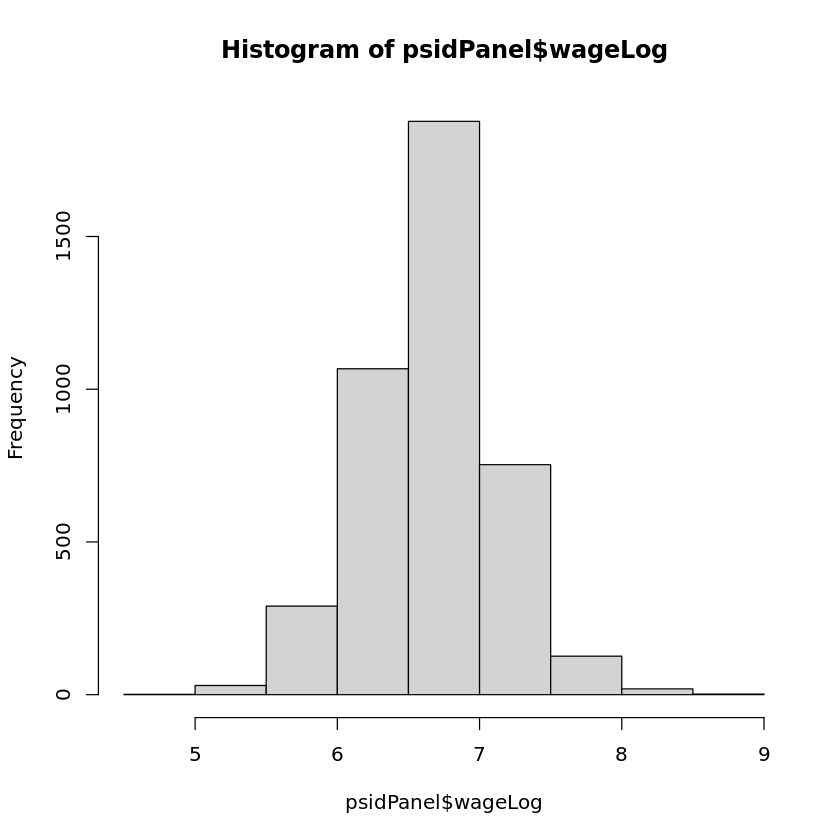

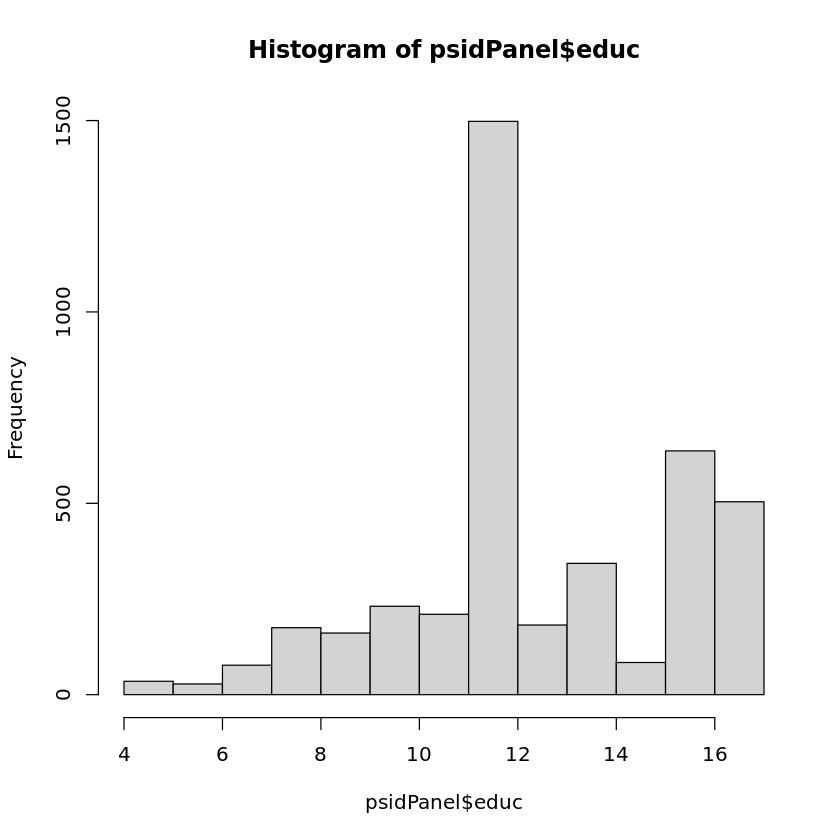

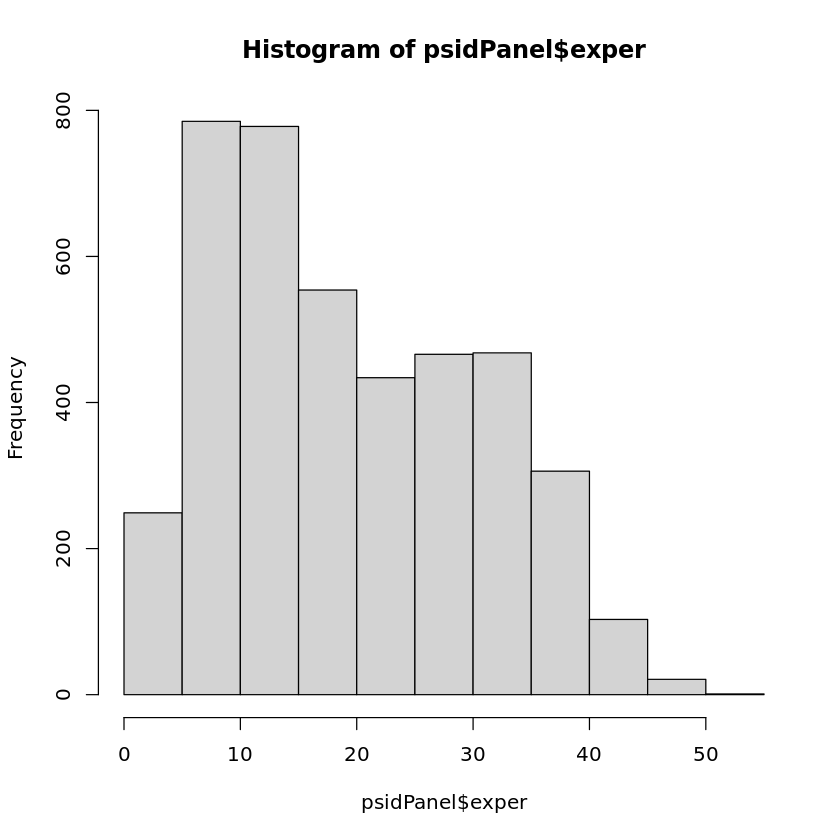

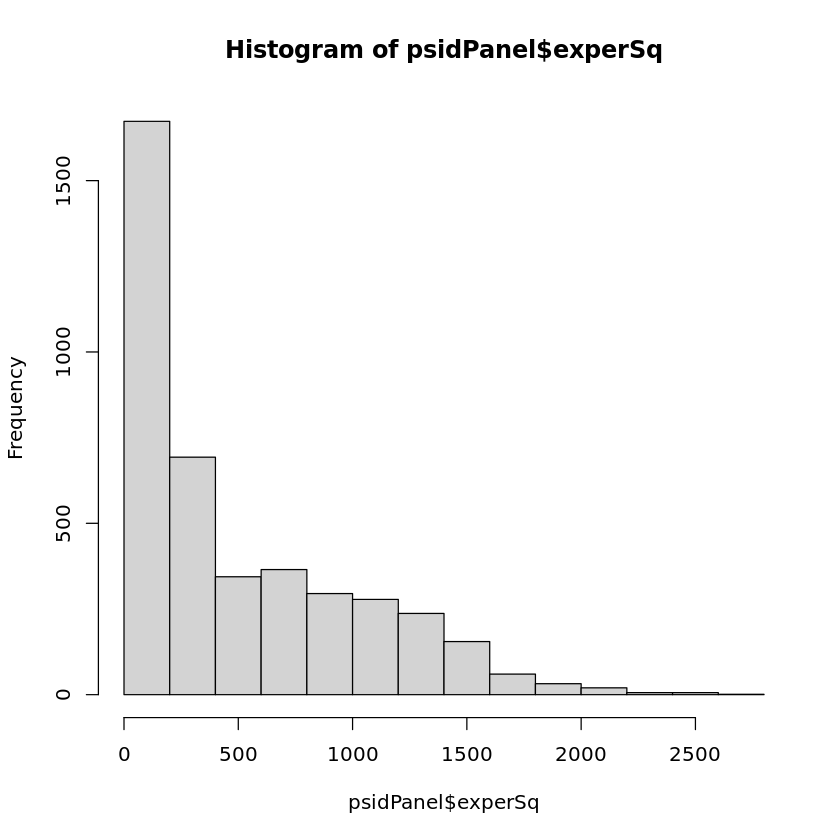

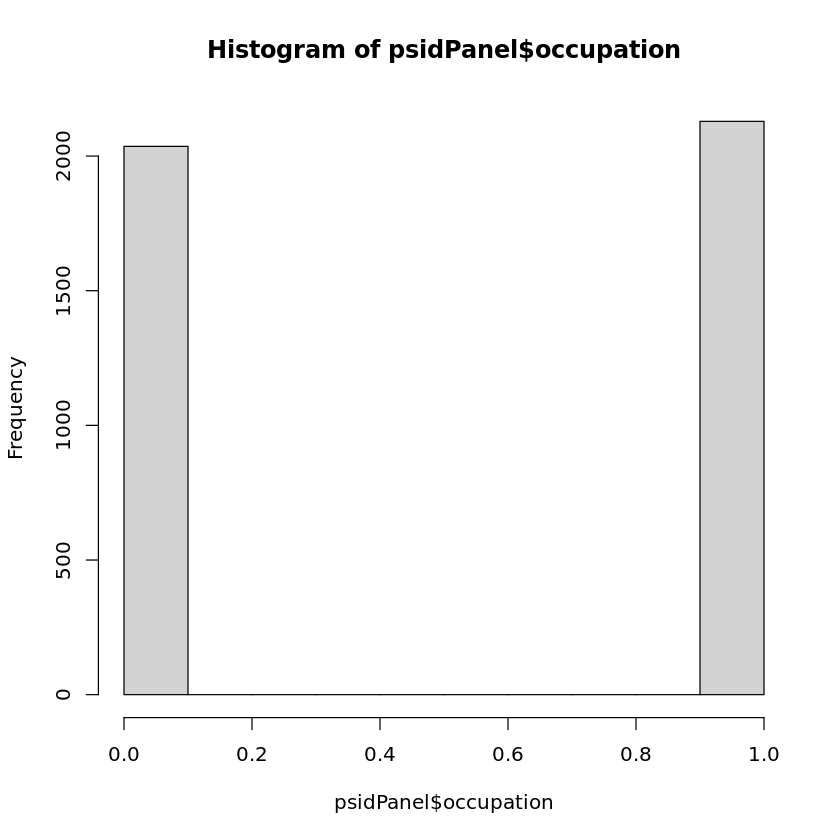

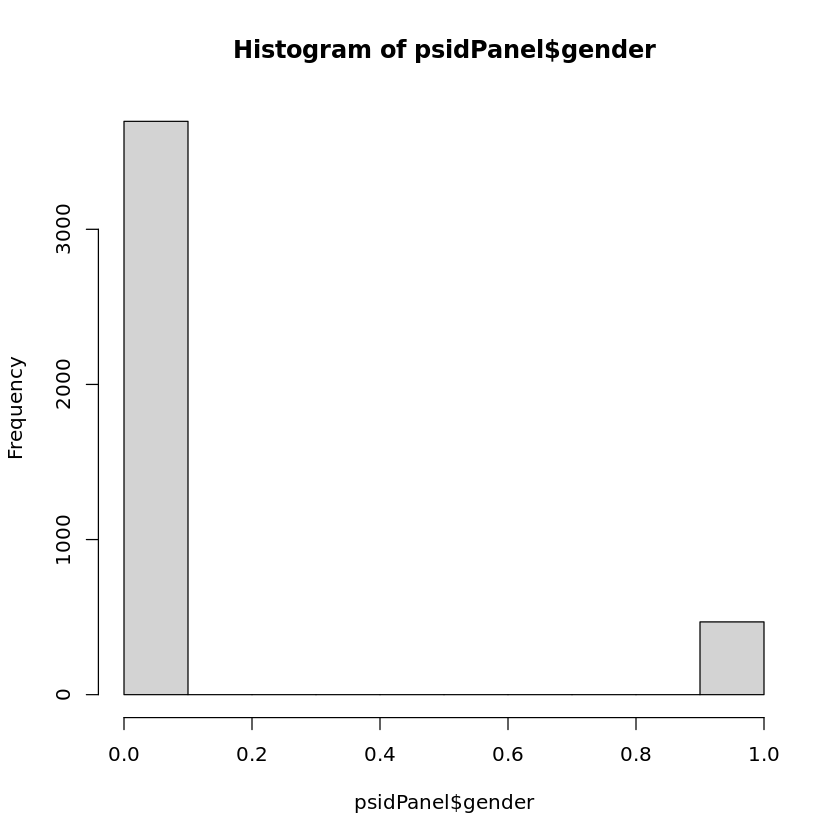

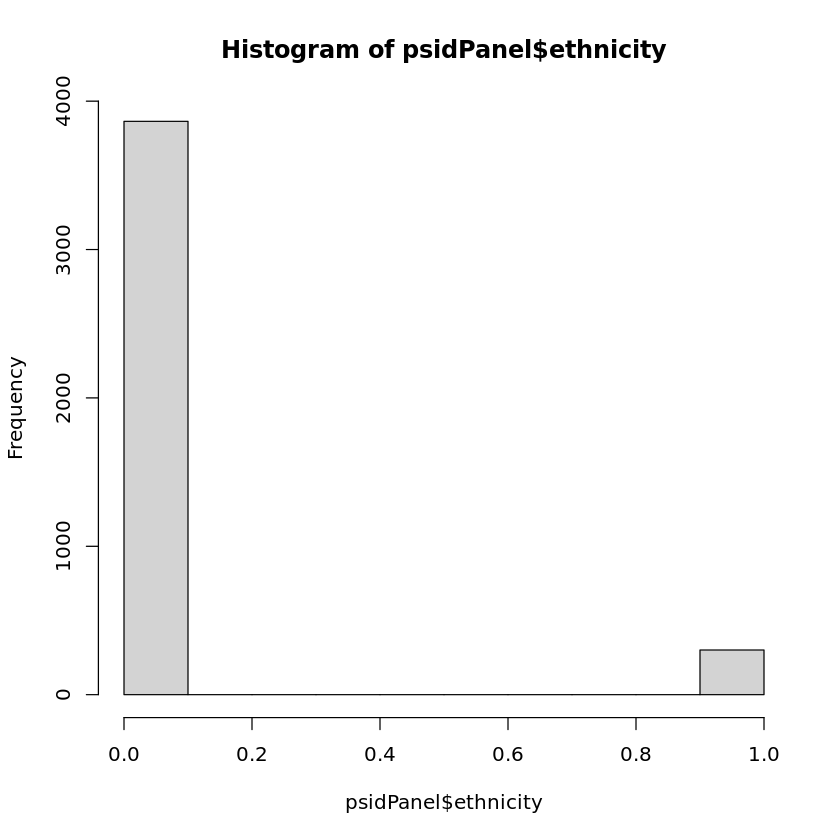

In [6]:

hist(psidPanel$wageLog)
hist(psidPanel$educ)
hist(psidPanel$exper)
hist(psidPanel$experSq)
hist(psidPanel$occupation)
hist(psidPanel$gender)
hist(psidPanel$ethnicity)

### (iv)

Based on the histograms you obtained in part (iii) is there a need for variable transformations?

#### Solution <a class="tocSkip">

Considering each variable in turn.

* `wageLog` is acceptably symmetrical, perhaps not surprisingly as it already is the logarithmic transformation of wage data. 

* `educ` shows a peak at the school leaving age (12 years), with a low level of observations below this point. Above that age, the distribution is approximately uniform. No transformation seems to be required.

* `exper` also looks approximately uniform except for the peak around 11 years. Again, it's not clear that transforming the data would help.  

* `experSq` shows considerable right skewness. However a log transformation does not appear to provide be enough improvement to warrant this extra transformation as you can see from the histogram given below.

* the remaining three variables, `occupation`, `gender`, and `ethnicity` are all binary variables, and treated as dummy or indicator variables; no transformation is required.

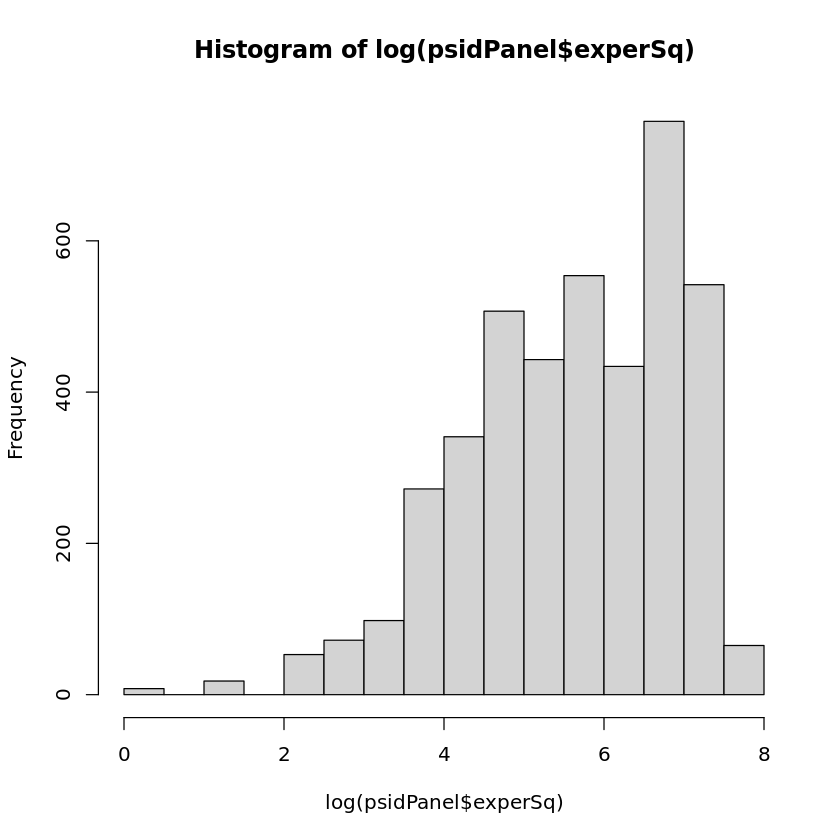

In [7]:
hist(log(psidPanel$experSq))

### (v)

By running the code below, confirm that `educ`, `gender` and `ethnicity` are time invariant but `exper`, `experSq`, and `occupation` are not. 

In [ ]:
max(by(psidPanel$educ, psidPanel$id, sd))
max(by(psidPanel$exper, psidPanel$id, sd))
max(by(psidPanel$experSq, psidPanel$id, sd))
max(by(psidPanel$occupation, psidPanel$id, sd))
max(by(psidPanel$gender, psidPanel$id, sd))
max(by(psidPanel$ethnicity, psidPanel$id, sd))

#### Solution <a class="tocSkip">

Recall from Notebook activity A1.8 that if a variable is time invariant, the maximum individual standard deviation must be zero.
So the results confirm that `educ`, `gender` and `ethnicity` are time invariant but that the remaining variables are not. We had already modelled this, with knowledge of this particular data set, in the introduction when we only used the subscript $i$ for the time invariant variables, but the subscripts $i$ and $t$ for the remaining ones.

## (c) Using a first difference (FD) estimator

In Subsection 7.1.1 you saw that for  $Y_{it}$ with stationary regressor $X_{it}$ the first difference (FD) estimator applies OLS to the following model

$Y_{i,t} − Y_{i,t−1} = \alpha_1 (Y_{i,t−1} − Y_{i,t−2}) + \alpha_2 (X_{i,t} − X_{i,t−1}) + \nu_{i,t} − \nu_{i,t−1}$.

Notice that this means the time series needs to be first differenced *within individuals*.

### (i)

By running the following code (which works for all balanced panels), create a new regressor, `diffWageLog`, which is the first differences within individuals for `wageLog` and add it to `psidPanel`. By comparing the first fourteen values of `wageLog` and `diffWageLog`, check that `diffWageLog` contains the values you expect it to have.

In [ ]:
psidPanel$diffWageLog <- as.vector(rbind(NA,diff(matrix(psid$wageLog, 
                                                        7, 595))))
head(psidPanel, 14)

#### Solution <a class="tocSkip">

As the output you obtained in part (a)(i) suggests, the first seven values of wageLog correspond to the values for the first individual whilst the next seven value correspond to the values for the second individuals.

The first value of diffWageLog (and the eighth) is not known. This is to be expected. For the first time period it is not possible to calculate the first difference because the value in the previous time period is not known.

The second value of diffWageLog is 0.1596 (to 4 d.p.) this corresponds to the difference in the values of wageLog in the second and first time periods for the first individual ($5.7203−5.5607$).

Similarly the ninth value of diffWageLog is 0.0513 (to 4 d.p.) this corresponds to the difference in the values of wageLog in the second and first time periods for the second individual ($6.2146−6.1633$).

And so on.

### (ii)

By copying and adapting the code in part (c)(i), calculate the first differences within individuals for all regressors, storing the values in objects called `diffEduc`, `diffExper`, `diffExperSq`, `diffOccupation`, `diffGender`, and `diffEthnicity` respectively and add them to `psidPanel`. By obtaining the first 14 rows of check that the new variables contain the values you expect them to have.

#### Solution <a class="tocSkip">

The required code and resulting output are given below.

In [10]:
psidPanel$diffEduc <- as.vector(rbind(NA,diff(matrix(psidPanel$educ, 
                                                     7, 595))))
psidPanel$diffExper <- as.vector(rbind(NA,diff(matrix(psidPanel$exper, 
                                                     7, 595))))
psidPanel$diffExperSq <- as.vector(rbind(NA,diff(matrix(psidPanel$experSq,
                                                     7, 595))))
psidPanel$diffOccupation <- as.vector(rbind(NA,diff(matrix(psidPanel$occupation,
                                                     7, 595))))
psidPanel$diffGender <- as.vector(rbind(NA,diff(matrix(psidPanel$gender,
                                                     7, 595))))
psidPanel$diffEthnicity <- as.vector(rbind(NA,diff(matrix(psidPanel$ethnicity,
                                                     7, 595))))
head(psidPanel, 14)

exper occupation gender educ ethnicity wageLog period id experSq
1-1  3    0          0       9   0         5.56068 1      1     9   
1-2  4    0          0       9   0         5.72031 2      1    16   
1-3  5    0          0       9   0         5.99645 3      1    25   
1-4  6    0          0       9   0         5.99645 4      1    36   
1-5  7    0          0       9   0         6.06146 5      1    49   
1-6  8    0          0       9   0         6.17379 6      1    64   
1-7  9    0          0       9   0         6.24417 7      1    81   
2-1 30    1          0      11   0         6.16331 1      2   900   
2-2 31    1          0      11   0         6.21461 2      2   961   
2-3 32    1          0      11   0         6.26340 3      2  1024   
2-4 33    1          0      11   0         6.54391 4      2  1089   
2-5 34    1          0      11   0         6.69703 5      2  1156   
2-6 35    1          0      11   0         6.79122 6      2  1225   
2-7 36    1          0      11   0         6.81564 7      2  1296   
    diffWageLog diffEduc diffExper diffExperSq diffOccupation diffGender
1-1         NA  NA       NA        NA          NA             NA        
1-2 0.15963030   0        1         7           0              0        
1-3 0.27613974   0        1         9           0              0        
1-4 0.00000000   0        1        11           0              0        
1-5 0.06501007   0        1        13           0              0        
1-6 0.11232996   0        1        15           0              0        
1-7 0.07038021   0        1        17           0              0        
2-1         NA  NA       NA        NA          NA             NA        
2-2 0.05130005   0        1        61           0              0        
2-3 0.04878998   0        1        63           0              0        
2-4 0.28050995   0        1        65           0              0        
2-5 0.15312004   0        1        67           0              0        
2-6 0.09419012   0        1        69           0              0        
2-7 0.02441978   0        1        71           0              0        
    diffEthnicity
1-1 NA           
1-2  0           
1-3  0           
1-4  0           
1-5  0           
1-6  0           
1-7  0           
2-1 NA           
2-2  0           
2-3  0           
2-4  0           
2-5  0           
2-6  0           
2-7  0

### (iii)

Why do the values you obtained in part (c)(ii) indicate there is a problem with including `diffEduc`, `diffExper`, `diffOccupation`, `diffGender`, and `diffEthnicity` in the model?

#### Solution <a class="tocSkip">

In all cases all the non-missing values have the same value, 0 (or 1 in the case of `diffExper`). If this is the case for all individuals (and it turns out that it is) it means that we will not be able to estimate the coefficients for most of the regressors in this model.

---

###  <a class="tocSkip">

The problem with estimating coefficients for time invariant regressors you probably expected. The problem with `diffExper` relates to the fact that the data collection took place annually, and experience was constructed as $\texttt{age} - \texttt{education}$, so no career breaks have been estimated in this model. This meant that everyone's experience increases by 1 each time period.

### (iv)

Using the code cell below estimate the Mincerian equation using the FD estimator and obtain a summary of the results.

#### Solution <a class="tocSkip">

The required code and resulting output are given below.

In [11]:
mincerFD <- lm(diffWageLog ~ diffEduc + diffExper + diffExperSq + 
                  diffOccupation + diffGender + diffEthnicity, data = psidPanel)
summary(mincerFD)


Call:
lm(formula = diffWageLog ~ diffEduc + diffExper + diffExperSq + 
    diffOccupation + diffGender + diffEthnicity, data = psidPanel)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.11346 -0.06556 -0.00940  0.04841  2.32980 

Coefficients: (4 not defined because of singularities)
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.1167705  0.0063056  18.519  < 2e-16 ***
diffEduc               NA         NA      NA       NA    
diffExper              NA         NA      NA       NA    
diffExperSq    -0.0005261  0.0001392  -3.781 0.000159 ***
diffOccupation -0.0238090  0.0137212  -1.735 0.082792 .  
diffGender             NA         NA      NA       NA    
diffEthnicity          NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1815 on 3567 degrees of freedom
  (595 observations deleted due to missingness)
Multiple R-squared:  0.004885,	Adjusted R-squared:  0.004327 


###  <a class="tocSkip">

It is also possible to implement the first difference estimator using the `plm()` function that is in the `plm` package. One advantage of doing so is that it avoids having to explcitly create the differenced regressors first. The basic command is

`panelFD <- plm(Y ~ x1 + x2 + ... +  xk, data = panelDataFrame, effect = "individual", model = "fd")`.

Notice that the only difference between this and the command given in Notebook activities A1.7, A1.8 and A1.9 is that the `model` argument is now `model = "fd"`.

### (v) 

Adapt the code above to estimate the Mincerian equation in part (iv) using `plm` on a panel data frame based on `psidPanel`.

In [12]:
# panelFD <- plm(Y ~ x1 + x2 + ... +  xk, data = panelDataFrame, 
#                    effect = "individual", model = "fd")
# summary(panelFD)

#### Solution <a class="tocSkip">

The required code and resulting output are given below.

In [13]:
psidFDFit <- plm(wageLog ~ educ + exper + experSq + occupation + gender + 
                 ethnicity,  data = psidPanel, 
                 effect = "individual", model = "fd")
summary(psidFDFit)

Oneway (individual) effect First-Difference Model

Call:
plm(formula = wageLog ~ educ + exper + experSq + occupation + 
    gender + ethnicity, data = psidPanel, effect = "individual", 
    model = "fd")

Balanced Panel: n = 595, T = 7, N = 4165
Observations used in estimation: 3570

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-2.1134638 -0.0655616 -0.0093987  0.0484105  2.3298043 

Coefficients:
               Estimate  Std. Error t-value  Pr(>|t|)    
(Intercept)  0.11677047  0.00630560 18.5185 < 2.2e-16 ***
experSq     -0.00052606  0.00013915 -3.7805 0.0001591 ***
occupation  -0.02380902  0.01372120 -1.7352 0.0827919 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    118.06
Residual Sum of Squares: 117.49
R-Squared:      0.004885
Adj. R-Squared: 0.0043271
F-statistic: 8.75523 on 2 and 3567 DF, p-value: 0.00016105

### (vi)

Compare the results obtained in part (v) with the results in part (iv).

#### Solution <a class="tocSkip">

The results from part (iv) and part (v) are the same. In terms of coefficient estimates, their statistical significance test statistics, and in terms of goodness of fit measures. Notice also that the $R^2$ is extremely low.

Any standard error correction the `plm()` command may have done did not have discernible effects on the results. But using it meant that in one output we obtain: how many individuals and time periods the data set has (which we did manually in part (b)(i)), that the data form a balanced panel (part (b)(ii)), all variable transformations (done in parts (c)(i) and (c)(ii)), which first differences are time invariant (part (c)(iii)), and the estimation results (part (c)(iv)). It is handy!

## (d) Lag dependence of log wages in the `psid`

The first differenced estimator, contrary to the within groups estimator, does not require strict exogeneity. However, it still requires that last period's error does not influence current period's regressors. But in the presence of "within-individual" lag dependence, the first differenced estimator is biased. 

This panel only has 7 time periods, which is a short time series structure in order to to use time series tools and tests in a reliable way. However, we can visually inspect the within-individuals serial correlations to look out for the presence of lag dependence.

Let's investigate the time properties of log wages. One way of doing this is to calculate the autocorrelations within individuals.

### (i) 

Calculate the first autocorrelations within individuals, and obtain a histogram of them by running the following code. Does there appear to be lag dependence?

In [ ]:
# Create the lag of order 1 of wageLog
psidPanel$lagWageLog <- lag(psidPanel$wageLog)

# Visualising the data and confirming the new variable does what it should
head(psidPanel[,c("id", "period", "wageLog", "lagWageLog")], 14)
tail(psidPanel[,c("id", "period", "wageLog", "lagWageLog")], 14)

#Creating the within-groups correlations
wageLogCorr <- by(data.frame(a = psidPanel$wageLog, b = psidPanel$lagWageLog),
                      psidPanel$id, 
                      function(df){cor(df$a[!is.na(df$b)],df$b[!is.na(df$b)])})

# creating the histogram of autocorrelations
hist(wageLogCorr)

#### Solution <a class="tocSkip">

Generally the autocorrelations seem to be far enough from zero, most are quite close to 1, which suggests that generally there is some lag dependence. When we compute the lag dependence of the first differenced log wages, the bulk of these correlations are closer to zero, which suggests a lag dependence of order 1 should be modelled.

### (ii)

Repeat the analysis in part (i), this time for the first differences of log wages. Does there appear to be lag dependence for the first differences?

In [ ]:
# Create the lag of order 1 of wageLog
psidPanel$lagDiffWageLog <- lag(psidPanel$diffWageLog)

# Visualising the data and confirming the new variable does what it should
head(psidPanel[,c("id", "period", "diffWageLog", "lagDiffWageLog")], 14)
tail(psidPanel[,c("id", "period", "diffWageLog", "lagDiffWageLog")], 14)

#Creating the within-groups correlations
diffWageLogCorr <- by(data.frame(a = psidPanel$diffWageLog, 
                                 b = psidPanel$lagDiffWageLog),
                      psidPanel$id, 
                      function(df){cor(df$a[!is.na(df$b)],df$b[!is.na(df$b)])})

# creating the histogram of autocorrelations
hist(diffWageLogCorr)

#### Solution <a class="tocSkip">

When we compute the lag dependence of the first differenced log wages, the bulk of these correlations are closer to zero, which suggests a lag dependence of order 1 should be modelled.

## (e) Using the Anderson-Hsiao (AH) estimator

In part (d) you saw that the autocorrelation of `wageLog` would cause the FD estimator to be biased. 

If this is true, the original model should be:

$ \texttt{wageLog}_{it} = \alpha_0 + \alpha_1 \texttt{wageLog}_{i(t-1)} + \alpha_2\ \texttt{educ}_{i} + \alpha_3\ \texttt{exper}_{it} + \alpha_4\ \texttt{exper}^2_{it} + \alpha_5\ \texttt{occupation}_{it} + \alpha_6\ \texttt{gender}_{i} + \alpha_7\ \texttt{ethnicity}_{i} + u_{it}$


where $u_{it}$ includes the fixed effect. By first differencing,

$\Delta \texttt{wageLog}_{it} = \alpha_1 \Delta \texttt{wageLog}_{i(t-1)} +\alpha_4\ \Delta{\texttt{exper}^2_{it}} +\alpha_5\ \Delta{\texttt{occupation}_{it}} + u_{it}-u_{i(t-1)}$


The fixed effect is removed but $\Delta \texttt{wageLog}_{i(t-1)}$ is now correlated with $u_{it}-u_{i(t-1)}$. The Anderson-Hsiao estimator uses an instrumental variable approach to dealing with the bias. As instruments they suggest using the twice lagged level of the dependent variable, $\texttt{wageLog}_{i(t-2)}$, as an instrument for $\Delta \texttt{wageLog}_{i(t-1)}$. By construction, $\texttt{wageLog}_{i(t-2)}$ is not correlated with the error term $u_{it}-u_{i(t-1)}$ but is correlated with the endogenous variable $\Delta \texttt{wageLog}_{i(t-1)}$. In theory, the first differences of the first differences of $\texttt{wageLog}_{it}$, lets denote this $\Delta^2\texttt{wageLog}_{it}$, could also work, but the correlation with the included regressor may be too small, making this instrument unstable. Lagged levels are often preferred to lagged differences in the AH estimator, or the inclusion of both can also be used. We will only use the lagged level variable in this activity.

Recall from Subsection 4.3.3, Unit A1 that estimation using instrumental variables can be done in two stages. For a regression model of the form 

$Y_i = a + b X_i + c W_i + u_i$

1. Estimate the relationship between the instrument $Z$ and the endogenous regressor $X$, and use this to predict values, $\widehat{X}$ , of $X$ regressed on $Z$ and $W$.

2. Use the predicted values, $\widehat{X}$ , in place of $X$ in the original regression model. That is, fit the model $Y_i = a + b\widehat{X}_i + c W_i + e_i$.

### (i)

Run the following code to calculate the instrumental variable $\texttt{wageLog}_{i(t-2)}$ and to create the transformations of variables needed in the Anderson-Hsiao model (these are $\Delta \texttt{wageLog}_{i(t-1)}$, $\Delta \texttt{experSq}_{it}$ and $\Delta \texttt{occupation}_{it})$.

In [ ]:
# x1 is the lagged first difference of wageLog
psidPanel$x1 <- psidPanel$diffWageLog - 
        as.vector(rbind(NA,diff(matrix(psidPanel$diffWageLog, 7, 595))))
# x2 is the first difference of experSq
psidPanel$x2 <- psidPanel$diffExperSq
# x3 is the first difference of occupation
psidPanel$x3 <- psidPanel$diffOccupation

# z1 is lag 2 of wageLog
psidPanel$z1 <- lag(psidPanel$lagWageLog)

# visualising the data
head(psidPanel[,c("id","period", "wageLog","lagWageLog", "diffWageLog", 
                      "x1", "experSq", "x2", "occupation", "x3", "z1")], 14)
tail(psidPanel[,c("id","period","wageLog","lagWageLog", "diffWageLog", 
                      "x1", "experSq", "x2", "occupation", "x3", "z1")], 14)


###  <a class="tocSkip">

Using these instrumental variables we then need to fit the following two regressions:
* `x1 ~ z1 + x2 + x3`
* `diffWageLog ~ x1Hat + x2 + x3`

### (ii)

Using the code cell below, fit the regressions for `x1` and `diffWageLog`, saving the results in objects called `modelX1` and `mincerAH` respectively.

#### Solution <a class="tocSkip">

The required code is given below. Note that running this code will not produce any output.

In [17]:
modelX1 <- lm(x1 ~ z1 + x2 + x3, data = psidPanel)

### (iii)

Run the following code to obtain the predicted values `x1Hat` and add them to `psidPanel`. Note this command has an extra argument `na.action = na.pass`. This is added to ensure that the missing values in `psidPanel` are handled in an appropriate way.

In [18]:
psidPanel$x1Hat <- predict(modelX1, newdata = psidPanel, na.action = na.pass)

### (iv)

Using the code cell below, fit the regression for `diffWageLog`, saving the results in objects called `mincerAH` and obtain a summary of the output.

#### Solution <a class="tocSkip">

The required code and resulting output are shown below.

In [19]:
mincerAH <- lm(diffWageLog ~ x1Hat + x2 + x3, data = psidPanel)
summary(mincerAH)


Call:
lm(formula = diffWageLog ~ x1Hat + x2 + x3, data = psidPanel)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.11329 -0.06193 -0.00860  0.04890  2.32895 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.1029358  0.0144511   7.123 1.32e-12 ***
x1Hat        0.0810428  0.1044203   0.776   0.4377    
x2          -0.0003392  0.0001692  -2.004   0.0451 *  
x3          -0.0329458  0.0159561  -2.065   0.0390 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1903 on 2971 degrees of freedom
  (1190 observations deleted due to missingness)
Multiple R-squared:  0.003407,	Adjusted R-squared:  0.002401 
F-statistic: 3.386 on 3 and 2971 DF,  p-value: 0.0174


###  <a class="tocSkip">

The method used in parts (d)(ii) to (d)(iv) are handy as they allow us to see, step by step, what the AH estimator entails. However, as well as being demanding in terms of coding and time, this method does not recognise that in the 2-step IV approach that one of the regressors in the second step is an estimate already and not raw data. We could add a step to our method to make this correction. Instead, we can, and will, use the `plm()` function in the `plm` package.

We can compute IV estimation (the  two steps combined) doing the following:

`IVmodel <- plm(Y ~ X + W | Z + W, data = panel_data_frame, model="pooling")`,

where we are regressing $Y$ on $X$ and $W$, but $X$ is endogenous and being instrumented with $Z$. $W$ is an exogenous regressor, so it is being instrumented as itself.

### (v)

Estimate the Mincerian equation 

$\Delta \texttt{wageLog}_{it} = \alpha_1 \Delta \texttt{wageLog}_{i(t-1)} +\alpha_4\ \Delta{\texttt{exper}^2_{it}} +\alpha_5\ \Delta{\texttt{occupation}_{it}} + u_{it}-u_{i(t-1)}$ 

using an Anderson-Hsiao estimator where the instrument is the twice lagged log of wages. Use the `plm()` function by adapting the code below. 

In [20]:
# IVmodel <- plm(Y ~ X + W | Z + W, data = panel_data_frame, model = "pooling")
# summary(IVmodel)

#### Solution <a class="tocSkip">

The required code and resulting output are as follows.

In [21]:
mincerAH <- plm(diffWageLog ~ x1 + x2 + x3 | z1 + x2 + x3, 
                  data = psidPanel, model="pooling")
summary(mincerAH)

Pooling Model
Instrumental variable estimation
   (Balestra-Varadharajan-Krishnakumar's transformation)

Call:
plm(formula = diffWageLog ~ x1 + x2 + x3 | z1 + x2 + x3, data = psidPanel, 
    model = "pooling")

Balanced Panel: n = 595, T = 5, N = 2975

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-2.2995780 -0.0641036 -0.0094656  0.0504685  2.4339968 

Coefficients:
               Estimate  Std. Error z-value  Pr(>|z|)    
(Intercept)  0.10293580  0.01489227  6.9120 4.778e-12 ***
x1           0.08104280  0.10760823  0.7531   0.45137    
x2          -0.00033922  0.00017440 -1.9450   0.05177 .  
x3          -0.03294580  0.01644322 -2.0036   0.04511 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    107.91
Residual Sum of Squares: 114.21
R-Squared:      0.064489
Adj. R-Squared: 0.063544
Chisq: 9.56387 on 3 DF, p-value: 0.022661

### (vi)

Compare the results you obtained in part (v) with those you obtained in part (iv).

#### Solution <a class="tocSkip">

As expected, the coefficient estimates are very similar but the standard errors have been corrected and are therefore larger than in (ii). The autoregressive term is not statistically significant, even though visually we strongly suspected that there was serial correlation in part (d). The visual inspection was misleading or, what is often the case in this estimator, the instrument was weak. By this we mean that its correlation with the endogenous regressor may have been too low for reliable estimation.

### (vii)

Compare the results you obtained for the Mincerian equation using the FD estimator and the AH estimator

#### Solution <a class="tocSkip">

Using the FD estimator, the coefficient associated with the experience term is $-0.00053$ (to five decimal places).

Using the AH estimator, the coefficient associated with the experience term is $-0.00034$ (to five decimal places).

Furthermore for the FD estimator this coefficient is statistically significant whereas it is not using the AH estimator, at least not at the 5% level. (This latter follows because increasing the standard error of a parameter means its $t$ value will increase and hence the $p$-value will get larger.)